In [35]:
import numpy as np
import glob
import csv as csv
import pandas as pd
import sys
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import Angle
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from matplotlib import gridspec
import os

In [7]:
#make sure these values are the same as when you made the novae
res = 0.1
x_min = -15
y_min = -15
z_min = -15

x_max = 15
y_max = 15
z_max = 15

x_grid = np.arange(x_min,x_max,res)
y_grid = np.arange(y_min,y_max,res)
z_grid = np.arange(z_min,z_max,res)

def get_positions(num,model):
    if(model=='good'):
        rho_complete = np.load('arrays/gal_den_Besancon_good_mass.npy')
    rho_complete_sum_x = np.sum(rho_complete,axis=(1,2))
    rho_complete_prob_x = rho_complete_sum_x/np.max(rho_complete_sum_x)

    rho_cumsum = np.cumsum(rho_complete_prob_x)
    #Aight, lets make a random number based on plot I might have to write my own
    inv_cumsum_rho = 1- rho_cumsum

    x_rand = np.zeros(num) #array to store random x values
    y_rand = np.zeros(num) #array to store random y values
    z_rand = np.zeros(num) #array to store random z values

    #loop through and generate num pairs of points
    for i in range(num):
        above = True #flag to keep track if value is under prob curve
        while(above):
            #pick a number between 0 and x
            x_try = (np.random.random()*x_max - res)*(2*np.random.randint(0,2)-1)#generate random number for x
            like_try = np.random.random()
            x_element = np.min(np.where(x_try<x_grid))
            if(like_try < rho_complete_prob_x[x_element]):
                x_rand[i] = x_try
                like_final = like_try
                el_final_x = x_element
                above= False
                break
#move on to get y value
        rho_complete_sum_y = np.sum(rho_complete[el_final_x,:,:],axis=1)
        rho_complete_prob_y = rho_complete_sum_y/np.max(rho_complete_sum_y)

        rho_cumsum_y = np.cumsum(rho_complete_prob_y)
        inv_cumsum_rho_y = 1- rho_cumsum_y

        above = True #flag to keep track if value is under prob curve
        while(above):
            #pick a number between 0 and y
            y_try = (np.random.random()*y_max  - res)*(2*np.random.randint(0,2)-1)
            like_try_y = np.random.random()
            y_element = np.min(np.where(y_try<y_grid))
            if(like_try_y < rho_complete_prob_y[y_element]):
                y_rand[i] = y_try
                like_final_y = like_try_y
                el_final_y = y_element
                above= False
                break

        #move on to get z value
        rho_complete_sum_z = rho_complete[el_final_x,el_final_y,:]
        rho_complete_prob_z = rho_complete_sum_z/np.max(rho_complete_sum_z)

        rho_cumsum_z = np.cumsum(rho_complete_prob_z)
        inv_cumsum_rho_z = 1- rho_cumsum_z

        above = True #flag to keep track if value is under prob curve
        while(above):
            #pick a number between 0 and z
            z_try = (np.random.random()*z_max  - res)*(2*np.random.randint(0,2)-1)
            like_try_z = np.random.random()
            z_element = np.min(np.where(z_try<z_grid))
            if(like_try_z < rho_complete_prob_z[z_element]):
                z_rand[i] = z_try
                like_final_z = like_try_z
                el_final_z = z_element
                above= False
                break
    
    #convert to polar
    R_rand = np.sqrt(x_rand**2 + y_rand**2)
    theta_rand = np.rad2deg(np.arccos(x_rand/R_rand))
    theta_rand[y_rand<0] = -1*theta_rand[y_rand<0] 

    return R_rand, z_rand, theta_rand,x_rand,y_rand

#Function takes the x,y,z positions of the model novae and makes a coordinate instance 
def get_coords_cart(x_rand,y_rand,z_rand):
    x_novae = x_rand #position of nova in Galactic corrdinates
    y_novae = y_rand #position of nova in Galactic corrdinates
    z_novae = z_rand 

    #position of Sun
    R_sol = 8.122 #kpc
    Theta_sol = np.pi
    x_sol = R_sol*np.cos(Theta_sol) #position of nova in Galactic corrdinates
    y_sol = R_sol*np.sin(Theta_sol) #position of nova in Galactic corrdinates
    z_sol =0.00

    #vector from sun to nova
    x_vector = x_novae - x_sol
    y_vector = y_novae  - y_sol
    r_vector_plane = np.sqrt(x_vector**2 + y_vector**2)
    z_vector = z_novae  - z_sol
    d_novae = np.sqrt(x_vector**2 + y_vector**2 + z_vector**2)

    #get galactic coordinates of object
    l_novae = np.rad2deg(np.arccos(x_vector/r_vector_plane))
    #deal with domain restriction of inverse cosine
    l_novae[y_vector<0] = np.rad2deg(-1*np.arccos(x_vector[y_vector<0]/r_vector_plane[y_vector<0]))
    l_novae = -l_novae #flip sign to get bar angle correct
    b_novae = np.rad2deg(np.arctan(z_vector/r_vector_plane))

    #make a Galactic coordinate instance inlcuding distance
    coords = SkyCoord(l_novae*u.deg, b_novae*u.deg,
                    distance=d_novae*u.kpc, frame='galactic')
    
    return coords

In [8]:
#generate N objects randomly based on number density models
#return positions in cylindrical and cartesian coordinates
num_novae = 1000

r_rand_b,z_rand_b,theta_rand_b,x_rand_b,y_rand_b  = get_positions(num_novae,'good')

coords_b = get_coords_cart(x_rand_b,y_rand_b,z_rand_b)

In [7]:
#cell writes the positions of the novae to a table
from astropy.table import Table, Column
#make a table full of RA and DEC
ra_deg = Column(coords_b.icrs.ra.deg,name='RA')
dec_deg = Column(coords_b.icrs.dec.deg,name='Dec')
distance = Column(coords_b.distance.value,name='distance')
names_tab = np.char.add(np.asarray(coords_b.icrs.ra.deg,dtype='U6'),np.asarray(coords_b.icrs.dec.deg,dtype='U6'))
lc_tab = Table((names_tab,ra_deg,dec_deg))
ascii.write(lc_tab,'data/nova_posit_10000asas.dat',format='csv',overwrite=True)

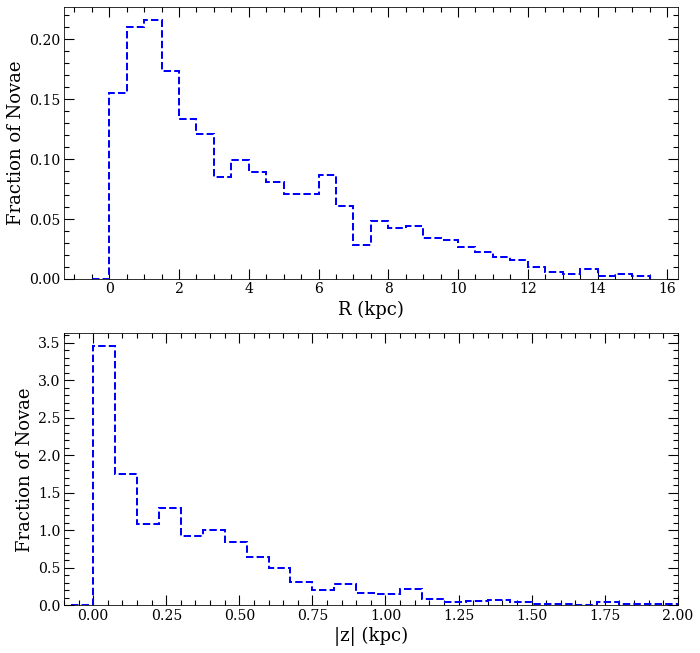

In [13]:
#histogram of r and z positions
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(11,11),nrows=2)
plt.rc('font', family='sans-serif')

ax[0].minorticks_on()
ax[0].tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
ax[0].tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
ax[0].tick_params(axis='both', labelsize=14)

#ax[0].set_ylabel('N',size=18)
ax[0].set_xlabel('R (kpc)',size=18) 
ax[0].set_ylabel('Fraction of Novae',size=18) 

ax[1].minorticks_on()
ax[1].tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
ax[1].tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
ax[1].tick_params(axis='both', labelsize=14)

#ax[1].set_ylabel('N',size=18)
ax[1].set_xlabel('|z| (kpc)',size=18) 
ax[1].set_ylabel('Fraction of Novae',size=18) 
ax[1].set_xlim(-0.1,2)

r_hist = ax[0].hist(r_rand_b,bins=np.arange(-0.5,16,0.5),linewidth=2,histtype='step',color='blue',linestyle='--',density=True)
r_hist = ax[1].hist(np.abs(z_rand_b),bins=np.arange(-0.075,5,0.075),linewidth=2,histtype='step',linestyle='--',color='blue',density=True)

#ax[0].legend(fontsize=12)
plt.show()

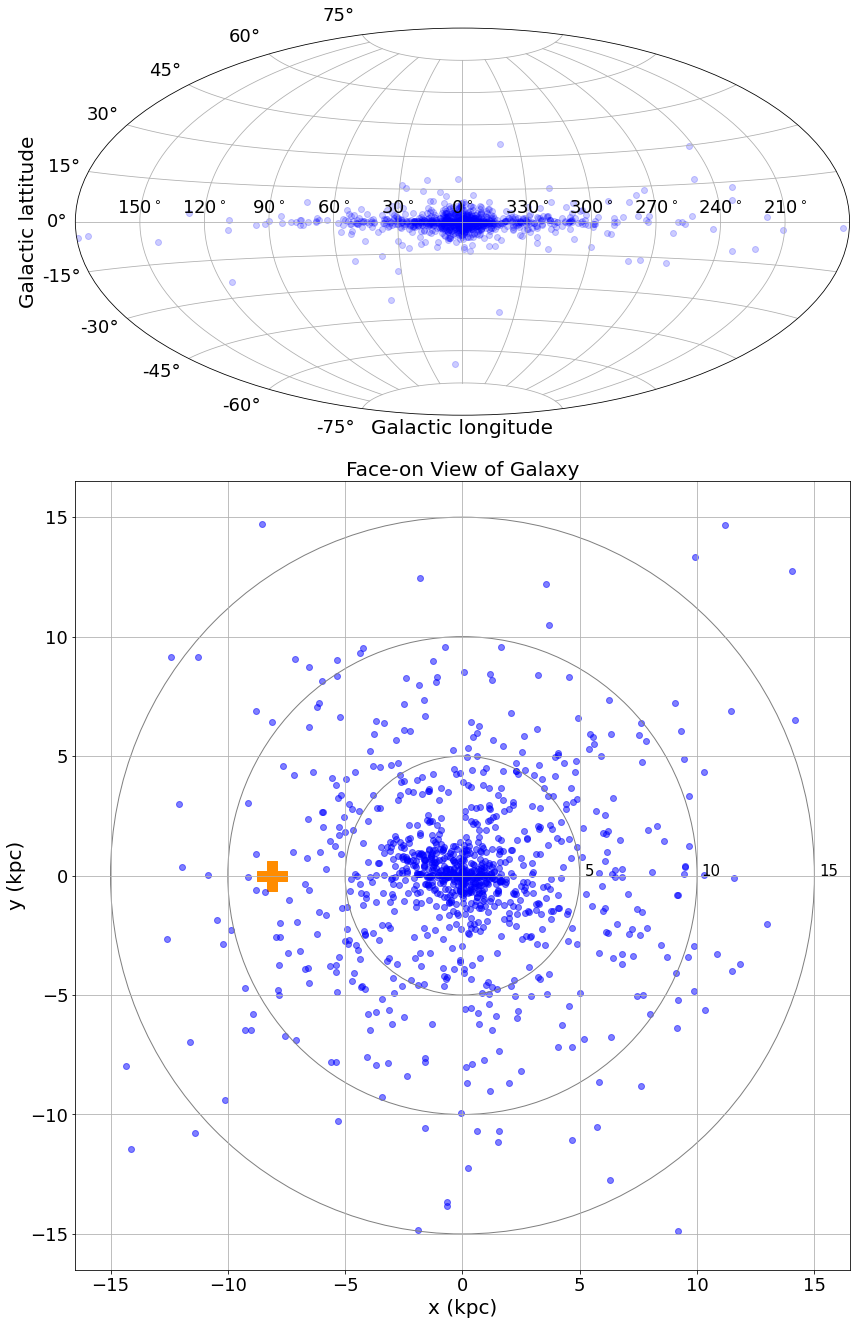

In [17]:
#plots positions in Galactic coordinates and a top down view
l_plot = Angle(coords_b.l).wrap_at(180*u.deg)
b_plot = Angle(coords_b.b)

import matplotlib.gridspec as gridspec

plt.rc('font', family='serif')
fig = plt.figure(figsize=(12,21))
spec2 = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
spec2.update(hspace=-0.4)
plt.rc('font', family='sans-serif')
ax1 = fig.add_subplot(spec2[0], projection="aitoff")
ax2 = fig.add_subplot(spec2[1:])
ax1.grid(True)
ax2.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax1.set_xticklabels([r'150$^\circ$',r'120$^\circ$',r'90$^\circ$',r'60$^\circ$',r'30$^\circ$',r'0$^\circ$',r'330$^\circ$',r'300$^\circ$',r'270$^\circ$',r'240$^\circ$',r'210$^\circ$'],size =18) #flip x-axis of gal plot


#ax1.set_title('Positions in Galactic Coordinates',size = 20)
ax1.set_xlabel('Galactic longitude',size=20)
ax1.set_ylabel('Galactic lattitude',size=20)

ax2.set_title('Face-on View of Galaxy',size = 20)
ax2.set_xlabel('x (kpc)',size=20)
ax2.set_ylabel('y (kpc)',size=20)

for i in range(1,4):
    circle = Circle((0,0), radius=int(i*5),facecolor = 'none',edgecolor='grey',linewidth = 1)
    ax2.add_patch(circle)
    ax2.annotate(str(i*5), xy = (int(i*5) + 0.2,0),size=15)

cm = plt.cm.get_cmap('nipy_spectral')
ax1.scatter(-l_plot.radian, b_plot.radian,alpha=0.2,color='blue')


R_sol = 8.122 #kpc
Theta_sol = np.deg2rad(180) #degrees
x_sol_b = R_sol*np.cos(Theta_sol) #position of nova in Galactic corrdinates
y_sol_b = -R_sol*np.sin(Theta_sol)#position of nova in Galactic corrdinates
z_sol_b =0

ax2.scatter(x_sol_b,y_sol_b,color='darkorange',s=900,marker='P')
ax2.scatter(x_rand_b,-y_rand_b, color = 'blue',alpha=0.5)

spec2.tight_layout(fig)
plt.savefig('../paper/figs/skymap_sim.png',bbox_inches='tight')

plt.show()

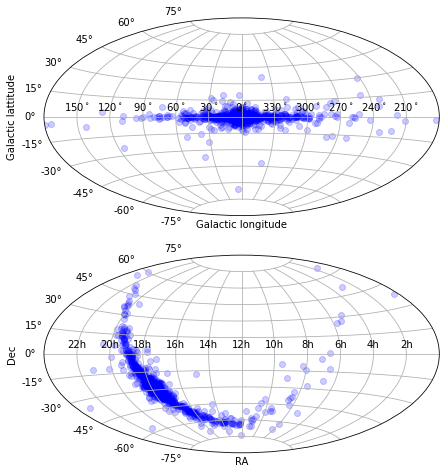

In [20]:
#plot Galactic and equatorial coordinates
l_plot_b = Angle(coords_b.l).wrap_at(180*u.deg)
b_plot = Angle(coords_b.b)

ra_plot = Angle(coords_b.icrs.ra.degree*u.deg) + 180*u.deg
ra_plot = ra_plot.wrap_at(180*u.deg)
dec_plot = Angle(coords_b.icrs.dec.degree*u.deg)

import matplotlib.gridspec as gridspec

plt.rc('font', family='serif')
fig = plt.figure(figsize=(12,8))
spec2 = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
plt.rc('font', family='sans-serif')
ax1 = fig.add_subplot(spec2[0], projection="aitoff")
ax2 = fig.add_subplot(spec2[1], projection="aitoff")
ax1.grid(True)
ax2.grid(True)
ax2.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax2.set_xticklabels(['22h','20h','18h','16h','14h','12h','10h','8h','6h','4h','2h']) #shifting by 12 hours

ax1.set_xticklabels([r'150$^\circ$',r'120$^\circ$',r'90$^\circ$',r'60$^\circ$',r'30$^\circ$',r'0$^\circ$',r'330$^\circ$',r'300$^\circ$',r'270$^\circ$',r'240$^\circ$',r'210$^\circ$']) #flip x-axis of gal plot


ax1.set_xlabel('Galactic longitude')
ax1.set_ylabel('Galactic lattitude')

ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')

cm = plt.cm.get_cmap('nipy_spectral')
ax1.scatter(-l_plot.radian, b_plot.radian,alpha=0.2,color='blue')
ax2.scatter(-ra_plot.radian, dec_plot.radian,alpha=0.2,color='blue')

#plt.savefig('../paper/figs/skymap_bad.png',bbox_inches='tight')

plt.show()

In [21]:
#QUERY THE DUST MAPS!
#download the dust maps from: https://github.com/jobovy/mwdust
#get the dust map from Bayestar19, Marshall06, and one more

os.environ['DUST_DIR'] = "/media/adam/TopBloke/DUST_DIR/mwdust-master/maps"
sys.path.insert(1,'/media/adam/TopBloke/DUST_DIR/mwdust-master')

import mwdust
combined19= mwdust.Combined19(filter='SDSS g')



In [22]:
#you can see which filters are available
from mwdust.util import extCurves
extCurves.avebvsf.keys()

dict_keys(['CTIO U', 'CTIO B', 'CTIO V', 'CTIO R', 'CTIO I', 'DSS-II g', 'DSS-II r', 'DSS-II i', 'SDSS u', 'SDSS g', 'SDSS r', 'SDSS i', 'SDSS z', 'UKIRT J', 'UKIRT H', 'UKIRT K', '2MASS J', '2MASS H', '2MASS Ks', 'IRAC-1', 'IRAC-2', 'IRAC-3', 'IRAC-4', 'WISE-1', 'WISE-2', 'Landolt U', 'WFPC2 F300W', 'Landolt B', 'WFPC2 F450W', 'Landolt V', 'WFPC2 F555W', 'Landolt R', 'WFPC2 F606W', 'Landolt I', 'WFPC2 F702W', 'WFPC2 F814W', 'WFC3 F105W', 'WFC3 F110W', 'WFC3 F125W', 'WFC3 F140W', 'WFC3 F160W', 'WFC3 F200LP', 'WFC3 F218W', 'UKIRT L"', 'WFC3 F225W', 'Gunn g', 'WFC3 F275W', 'Gunn r', 'WFC3 F300X', 'Gunn i', 'WFC3 F336W', 'Gunn z', 'WFC3 F350LP', 'Spinrad R_S', 'WFC3 F390W', 'Stromgren u', 'WFC3 F438W', 'Stromgren b', 'WFC3 F475W', 'Stromgren v', 'WFC3 F475X', 'Stromgren beta', 'WFC3 F555W', 'Stromgren y', 'WFC3 F600LP', 'WFC3 F606W', 'WFC3 F625W', 'WFC3 F775W', 'WFC3 F814W', 'WFC3 F850LP', 'ACS clear', 'ACS F435W', 'ACS F475W', 'PS1 g', 'ACS F550M', 'PS1 r', 'ACS F555W', 'PS1 i', 'ACS F60

In [23]:
dust_corr = 1.243
#get the g-band extinction
A_g_b = np.zeros(num_novae)
for i in range(num_novae):
    A_g_b[i] = combined19(coords_b.l.value[i],coords_b.b.value[i],coords_b.distance.value[i])

In [27]:
#model shafter extinction
a_v = 1. #mag per kpc in midplane
h_d = 0.1 #kpc scale height perpindicular to midplane
A_g_shaft = a_v*coords_b.distance.value*(h_d/np.abs(z_rand_b))*(1 - np.exp(-np.abs(z_rand_b)/h_d))    

In [28]:
#estimate peak apparent mag
Mg = np.random.normal(loc=-7.2,scale=0.8,size=num_novae) #peak absolute mag from Shafter distribution
mg_b = 5*np.log10(coords_b.distance.value*1000) - 5 + Mg + A_g_b
mg_shaft = 5*np.log10(coords_b.distance.value*1000) - 5 + Mg + A_g_shaft
mg_nodust = 5*np.log10(coords_b.distance.value*1000) - 5 + Mg

In [29]:
ra_b = coords_b.icrs.ra.deg
dec_b = coords_b.icrs.dec.deg

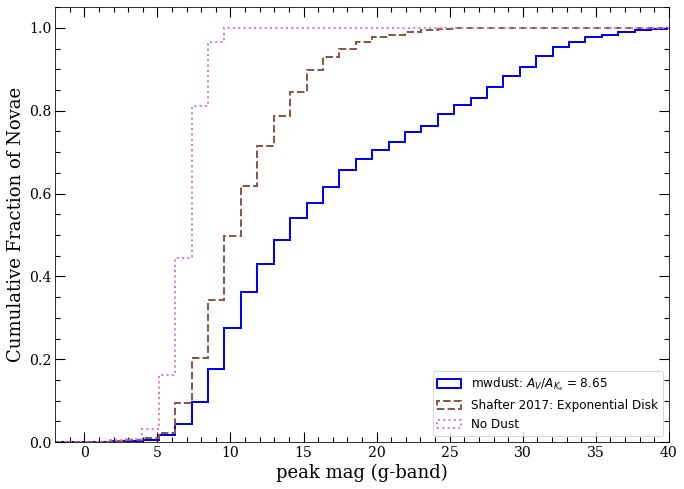

In [30]:
#plot how bright the novae are for the different dust models
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(11,8))
plt.rc('font', family='sans-serif')

ax.minorticks_on()
ax.tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
ax.tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
ax.tick_params(axis='both', labelsize=14)

plt.ylabel('Cumulative Fraction of Novae',size=18)
plt.xlabel(r'peak mag (g-band)',size=18) 

plt.gca().invert_xaxis()

#ax.annotate('Likely \ndiscovered', xy = (0,0.4),size=18)
#ax.annotate('Likely NOT discovered', xy = (20,0.4),size=18)

mv_hist = ax.hist(mg_b,bins=np.linspace(-5,50),color='blue',density=True,linewidth=2,histtype='step',cumulative=True,label=r'mwdust: $A_V/A_{K_s}$ = 8.65')
#mv_hist = ax.hist(mg_corr,bins=np.linspace(-5,50),color='red',density=True,linewidth=2,histtype='step',linestyle='dotted',cumulative=True,label=r'mwdust:  $A_V/A_{K_s}$ = 13.44')
#mv_hist_b = ax.hist(mg_b,bins=np.linspace(-5,50),color='red',density=True,linewidth=2,histtype='step',cumulative=True,label='3D Dust Maps: mwdust (I band)')
#mv_hist_c = ax.hist(mg_c,bins=np.linspace(-5,50),color='red',density=True,linewidth=2,histtype='step',cumulative=True,label='3D Dust Maps- Catun')

mv_hist_shaft = ax.hist(mg_shaft,bins=np.linspace(-5,50),color='tab:brown',density=True,linewidth=2,linestyle='--',histtype='step',cumulative=True,label='Shafter 2017: Exponential Disk')
mv_hist_nodust = ax.hist(mg_nodust,bins=np.linspace(-5,50),color='tab:pink',density=True,linewidth=2,linestyle=':',cumulative=True,histtype='step',label='No Dust')
#mv_hist_catun = ax.hist(nova_mag[nova_year>2000],bins=np.linspace(-5,50),color='orange',density=True,linewidth=2,linestyle='dashdot',cumulative=True,histtype='step',label='Discovered Novae')

plt.xlim(-2,40)


plt.legend(fontsize=12,loc=4)
plt.savefig('../paper/figs/mag_dist.png',bbox_inches='tight')
plt.show()

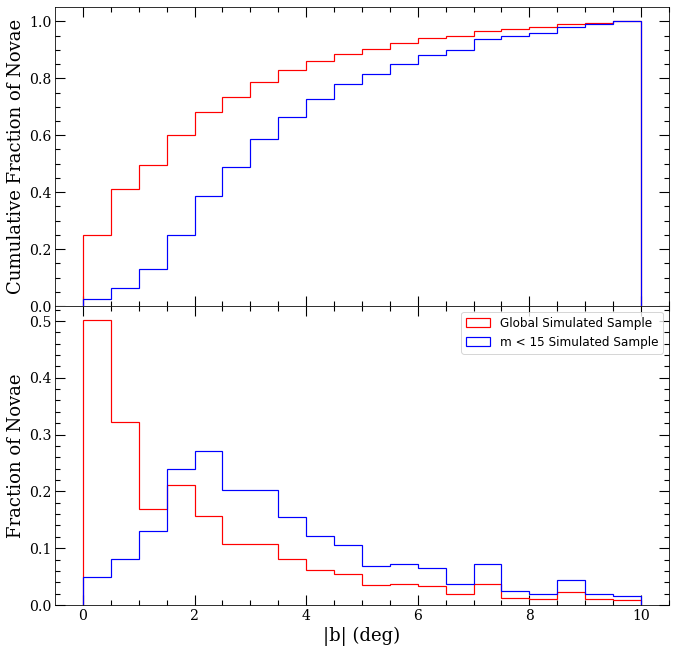

In [32]:
b_plot_b = Angle(coords_b.b)

plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(11,11),nrows=2,sharex=True)
plt.rc('font', family='sans-serif')
plt.subplots_adjust(wspace=0, hspace=0)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
ax[0].tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].set_ylabel('Cumulative Fraction of Novae',size=18)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
ax[1].tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
ax[1].tick_params(axis='both', labelsize=14)

ax[1].set_ylabel('Fraction of Novae',size=18)
ax[1].set_xlabel('|b| (deg)',size=18) 

b_bins = bins=np.arange(-0.0,10.5,0.5)

b_hist = ax[0].hist(np.abs(b_plot_b.deg),bins=b_bins,color='red', linewidth=1.2,density=True,histtype='step',cumulative=True)
b_hist_glob = ax[1].hist(np.abs(b_plot_b.deg),bins=b_bins,color='red', linewidth=1.2,density=True,histtype='step',label='Global Simulated Sample')

b_hist = ax[0].hist(np.abs(b_plot_b[mg_b<=15].deg),bins=b_bins,color='blue', linewidth=1.2,density=True,histtype='step',cumulative=True)
b_hist_fit = ax[1].hist(np.abs(b_plot_b[mg_b<=15].deg),bins=b_bins,color='blue', linewidth=1.2,density=True,histtype='step',label='m < 15 Simulated Sample')


plt.legend(fontsize=12)
#plt.savefig('../paper/figs/lb_hist.png',bbox_inches='tight')
plt.show()

In [ ]:
#This cell is slow but makes a dust map around the Galactic center
l_grid = np.arange(-30,30,0.25)
b_grid = np.arange(-10,10,0.25)
A_g_map = np.zeros((len(l_grid),len(b_grid)))

for i in range(len(l_grid)):
    for j in range(len(b_grid)):
        A_g_map[i,j] = combined19(l_grid[i],b_grid[j],15)

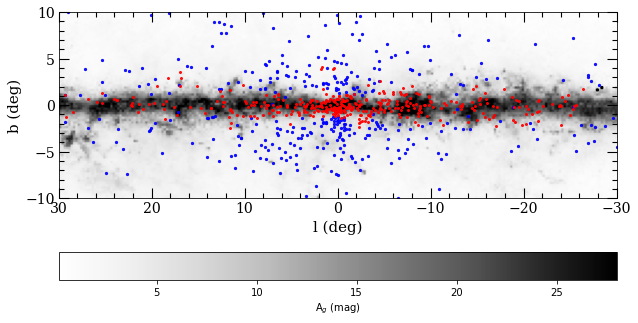

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(10,10))
plt.rc('font', family='sans-serif')

ax.minorticks_on()
ax.tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
ax.tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
ax.tick_params(axis='both', labelsize=14)
plt.xlim(-30,30)
plt.ylim(-10,10)

ax.set_xlabel('l (deg)',size=15)
ax.set_ylabel('b (deg)',size=15)
ax.invert_xaxis()
sc = ax.imshow(A_g_map.T,extent=(-30,30,-10,10),vmax=28,cmap='Greys')

plt.colorbar(sc,orientation="horizontal",pad=0.1,label=r'A$_g$ (mag)')

ax.scatter(l_plot_b[mg_b<15],b_plot_b[mg_b<15],s=5,alpha=0.9,color='blue')
ax.scatter(l_plot_b[mg_b>15],b_plot_b[mg_b>15],s=4,alpha=0.9,color='red')


plt.savefig('../paper/figs/map_model.png',bbox_inches='tight')
plt.show()

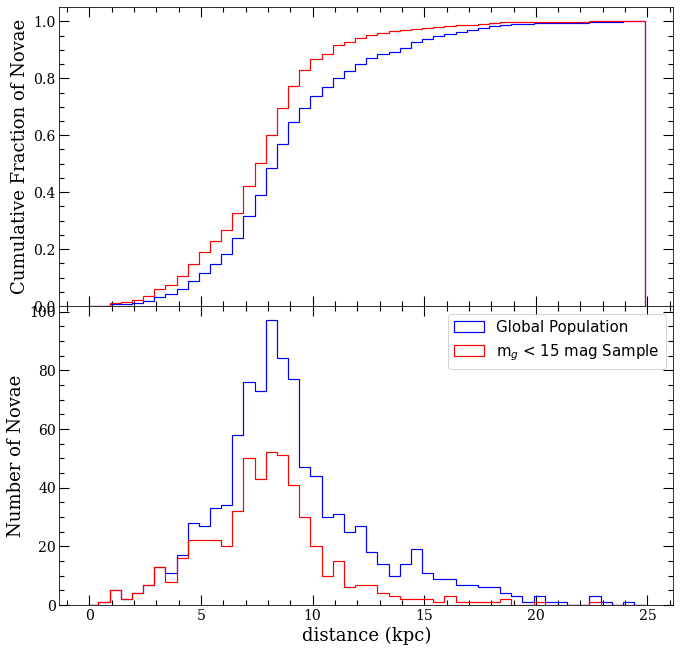

In [34]:
#This cell plots the distance to the novae
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(11,11),nrows=2,sharex=True)
plt.rc('font', family='sans-serif')
plt.subplots_adjust(wspace=0, hspace=0)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
ax[0].tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
ax[0].tick_params(axis='both', labelsize=14)


ax[1].minorticks_on()
ax[1].tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
ax[1].tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
ax[1].tick_params(axis='both', labelsize=14)

#ax[1].set_ylabel('N',size=18)
ax[1].set_xlabel('distance (kpc)',size=18) 
ax[1].set_ylabel('Number of Novae',size=18) 
ax[0].set_ylabel('Cumulative Fraction of Novae',size=18) 

d_hist = ax[1].hist(coords_b.distance.value,bins=np.arange(-0.1,25,0.5),color='blue', linewidth=1.2,histtype='step',label = 'Global Population')
d_hist = ax[1].hist(coords_b.distance.value[mg_b<15],bins=np.arange(-0.1,25,0.5),color='red', linewidth=1.2,histtype='step',label = r'm$_g$ < 15 mag Sample')
#d_hist = ax[1].hist(coords_b.distance.value,bins=np.arange(-0.1,25,0.5),color='green', linewidth=1.2,histtype='step',label = 'Global Population')

ax[0].hist(coords_b.distance.value,bins=np.arange(-0.1,25,0.5),color='blue', linewidth=1.2,density=True,histtype='step',cumulative=True)
ax[0].hist(coords_b.distance.value[mg_b<15],bins=np.arange(-0.1,25,0.5),color='red', linewidth=1.2,density=True,histtype='step',cumulative=True)

ax[1].legend(fontsize=15)
plt.show()